In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import pandas as pd
from StockTradingRLEnv_Abhi import StockTradingEnv
import matplotlib.pyplot as plt


In [2]:
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 8)
        self.fc4 = nn.Linear(8, output_dim)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        x = torch.nn.functional.softmax(x, dim=-1)
        return x

In [3]:
class Agent:
    def __init__(self, state_dim, is_eval=False, model_name=""):
        self.state_dim = state_dim
        self.action_dim = 3  # 0: Buy, 1: Sell 2: hold
        self.memory = deque(maxlen=1000)
        self.batch_size = 32
        self.gamma = 0.95
        self.epsilon = 1.0  # initial exploration rate
        self.epsilon_min = 0.01  # minimum exploration rate
        self.epsilon_decay = 0.995
        self.is_eval = is_eval
        
        self.model = DQN(state_dim, self.action_dim)
        self.target_model = DQN(state_dim, self.action_dim)
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.001)
        self.loss_fn = nn.MSELoss()
        
        if self.is_eval:
            self.model.load_state_dict(torch.load(f'saved_models/{model_name}'))
        
        self.update_target_model()
        
    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        
    def act(self, state):
        if not self.is_eval and random.random() <= self.epsilon:
            action_type = random.randrange(self.action_dim)  # 0 for buy, 1 for sell
            amount = random.random()  # percentage to buy/sell
            return [action_type, amount]
        state = torch.FloatTensor(state).unsqueeze(0)
        q_values = self.model(state)
        # print("q_values",q_values)
        action_type = torch.argmax(q_values[0]).item()
        # print("action_type",action_type)
        amount = random.random()  # percentage to buy/sell
        return [action_type, amount]
        
    def replay(self):
        if len(self.memory) < self.batch_size:
            return
        minibatch = random.sample(self.memory, self.batch_size)
        for state, action, reward, next_state, done in minibatch:
            state = torch.FloatTensor(state).unsqueeze(0)
            next_state = torch.FloatTensor(next_state).unsqueeze(0)
            target = self.model(state)[0]
            if done:
                target[action[0]] = reward
            else:
                t = self.target_model(next_state)[0]
                target[action[0]] = reward + self.gamma * torch.max(t).item()
            target = target.unsqueeze(0)
            output = self.model(state)
            loss = self.loss_fn(output, target)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def load(self, name):
        self.model.load_state_dict(torch.load(name))
        
    def save(self, name):
        torch.save(self.model.state_dict(), f'saved_models/{name}.pth')

In [4]:
MAX_ACCOUNT_BALANCE = 2147483647
MAX_NUM_SHARES = 2147483647
MAX_SHARE_PRICE = 5000
MAX_STEPS = 2000

# INITIAL_ACCOUNT_BALANCE = 10000

In [5]:
df = pd.read_csv('./data/^GSPC_2010-2015.csv')
df = df.sort_values('Date')
df.dropna(inplace=True)
df = df.reset_index(drop=True)

env = StockTradingEnv(df, render_mode='human')
state_dim = env.observation_space.shape[1] * env.observation_space.shape[0]
agent = Agent(state_dim=state_dim)

episodes = 1

In [6]:
net_worths = []

for e in range(episodes):
    state, _ = env.reset()
    state = state.flatten()  # Flatten the state to match the input dimensions of the network
    done = False
    for time in range(len(env.df)):
        if(time % 100 == 0):
            print(f"Time: {time} episode: {e+1}/{episodes} score: {env.net_worth}")
        action = agent.act(state)
        next_state, reward, done, truncated, _ = env.step(action)
        next_state = next_state.flatten()  # Flatten the next state
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        if done:
            agent.update_target_model()
            print(f'Episode {e+1}/{episodes} - Net Worth: {env.net_worth}')
            break
        agent.replay()
    net_worths.append(env.net_worth)
    if (e + 1) % 10 == 0:
        agent.save(f"model_dqn_{e+1}")
    agent.save("model_dqn_temp")
    print(f'Episode {e+1}/{episodes} - Net Worth: {env.net_worth}')

Time: 0 episode: 1/1 score: 10000


RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.FloatTensor [1, 3]], which is output 0 of SoftmaxBackward0, is at version 1; expected version 0 instead. Hint: enable anomaly detection to find the operation that failed to compute its gradient, with torch.autograd.set_detect_anomaly(True).

[10449.582311704262]


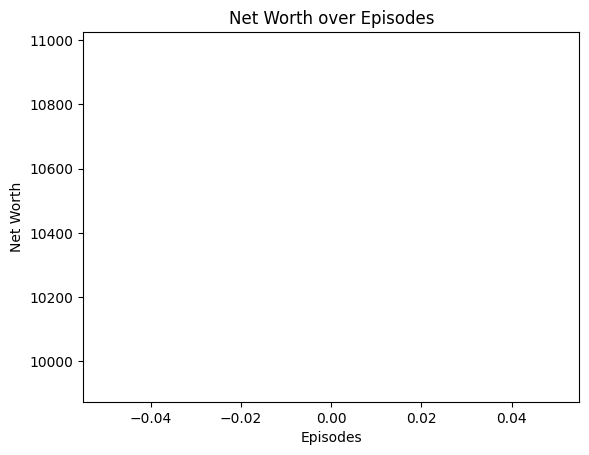

In [ ]:
print(net_worths)
# Plotting the net worth over episodes
plt.plot(range(episodes), net_worths)
plt.xlabel('Episodes')
plt.ylabel('Net Worth')
plt.title('Net Worth over Episodes')
plt.show()


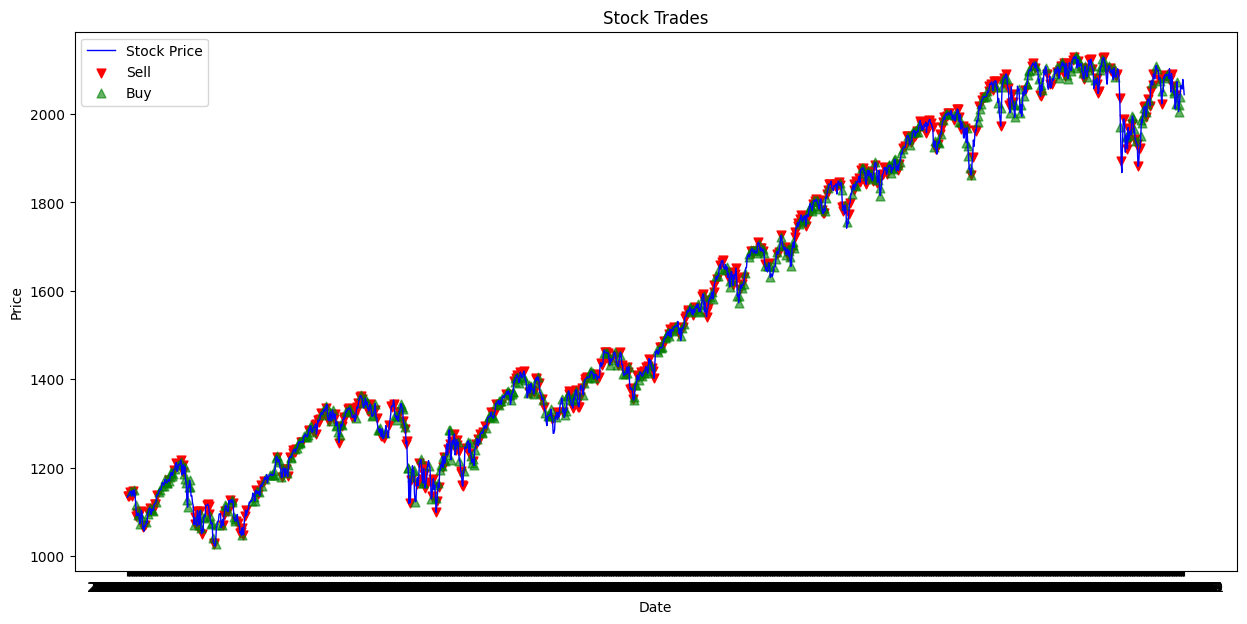

episode: 1/10 score: 8652.133402269028


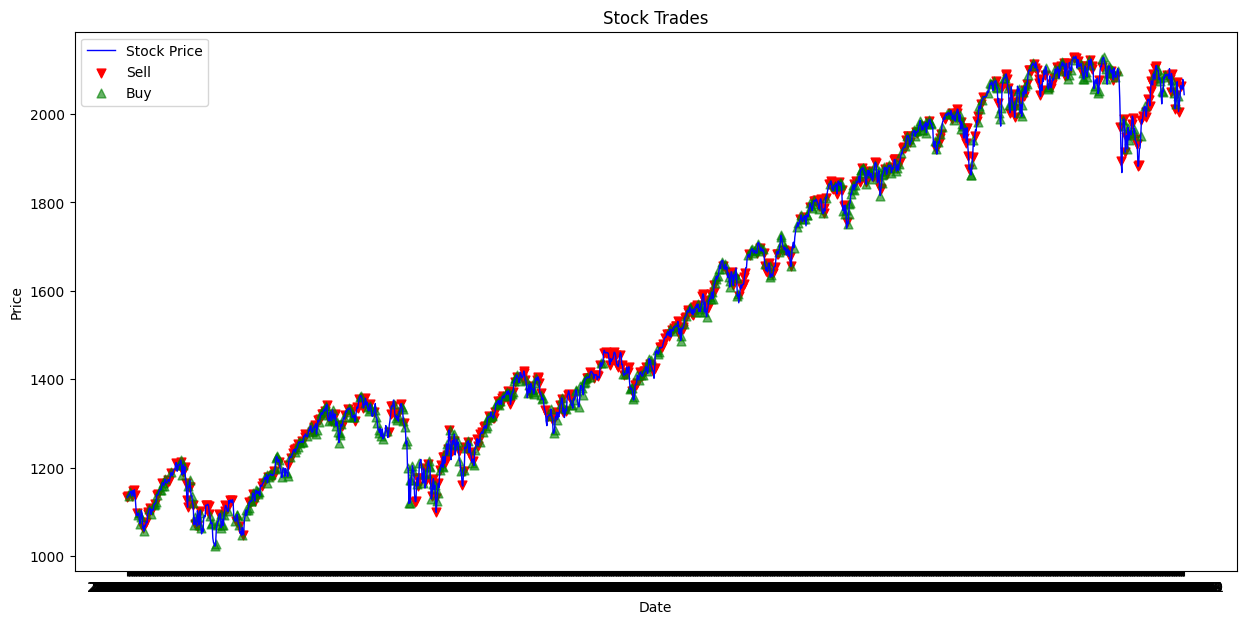

episode: 2/10 score: 11507.016406418505


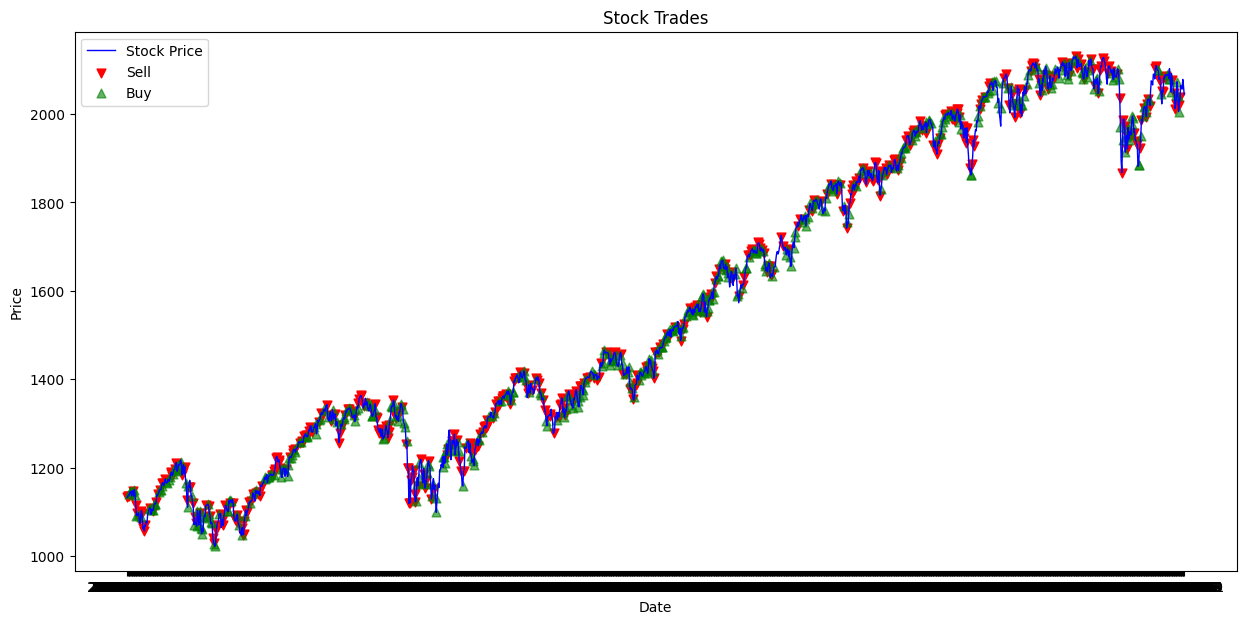

episode: 3/10 score: 13703.843783824774


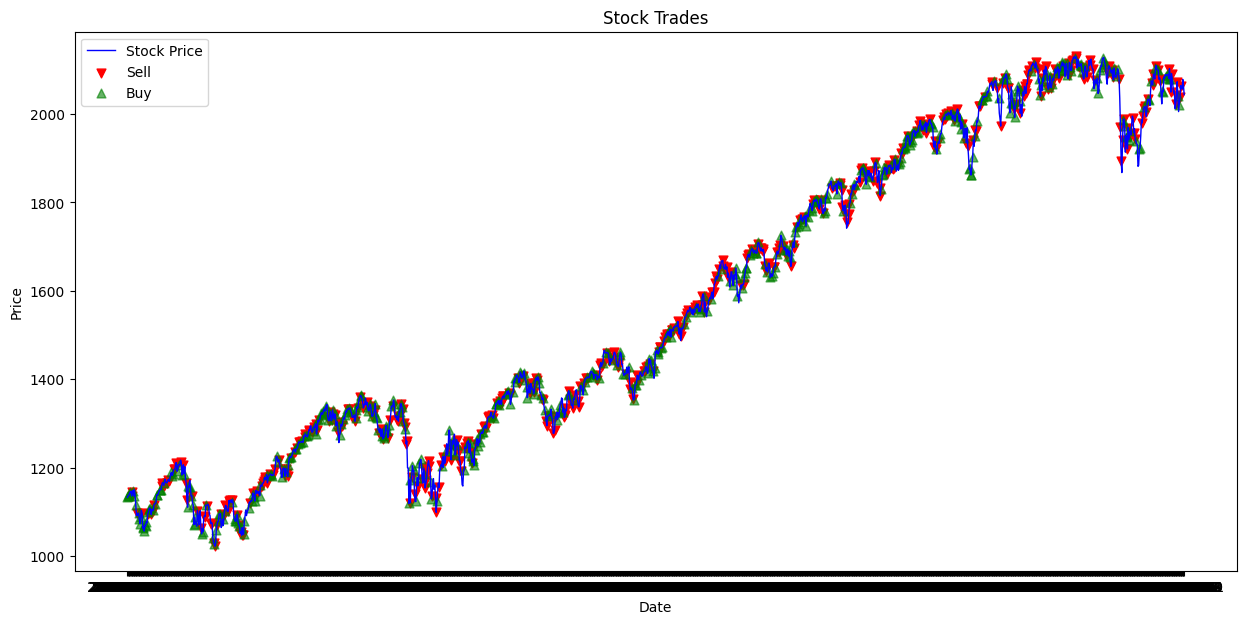

episode: 4/10 score: 13190.44684534541


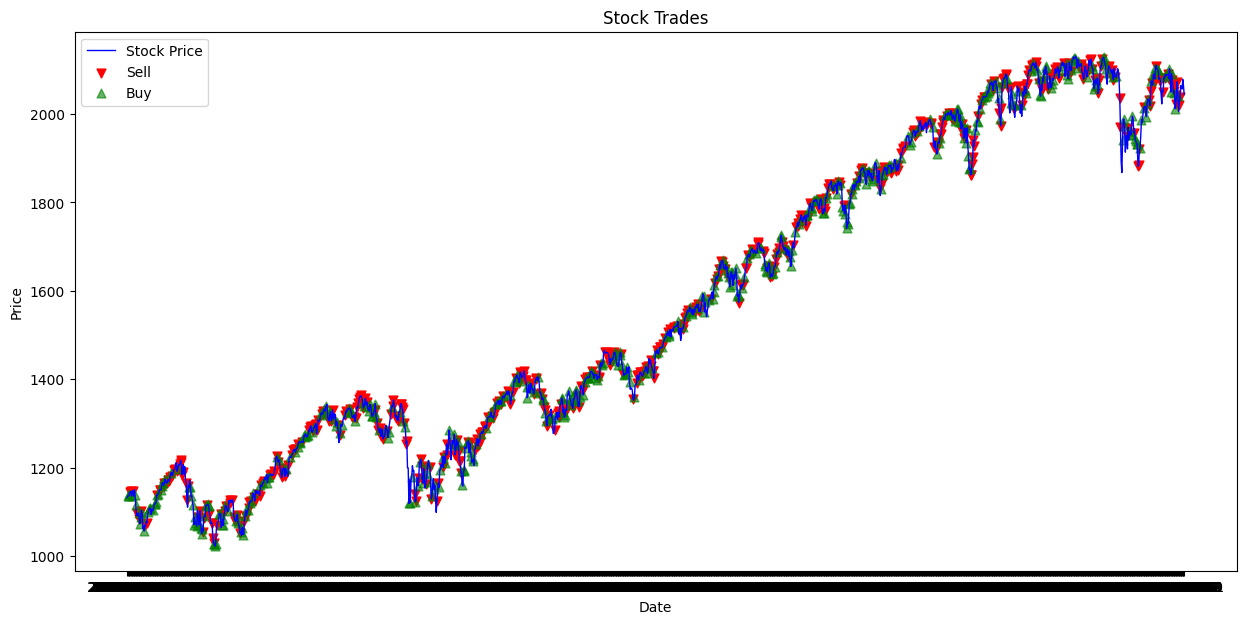

episode: 5/10 score: 12837.957587014234


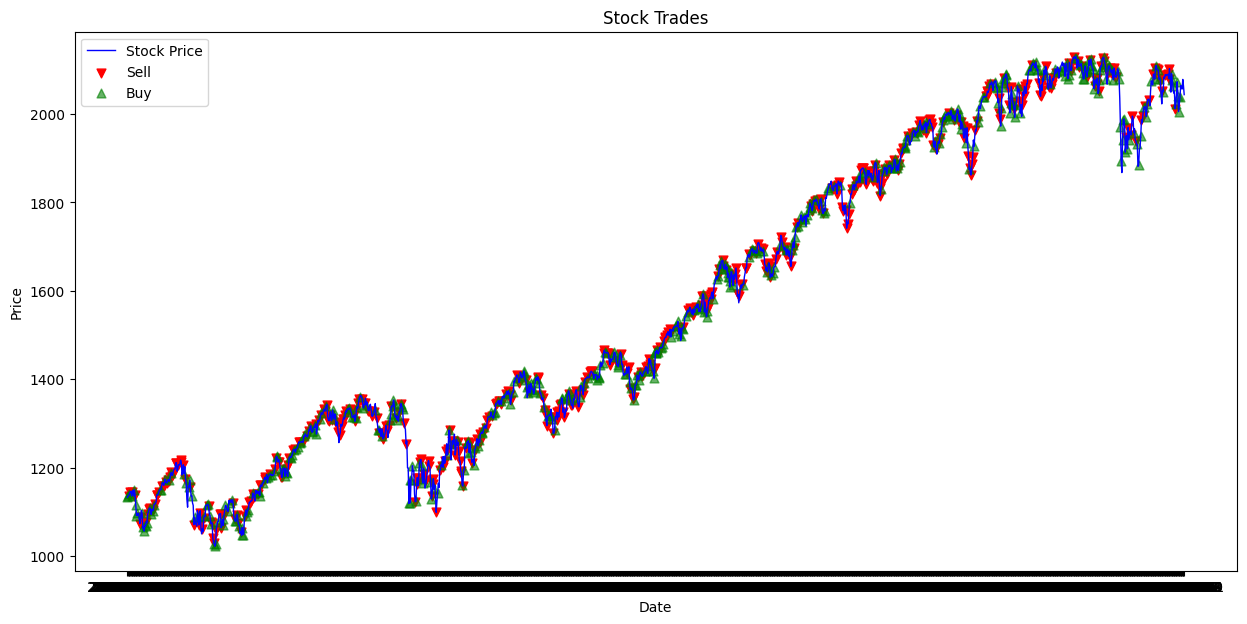

episode: 6/10 score: 10015.030063743532


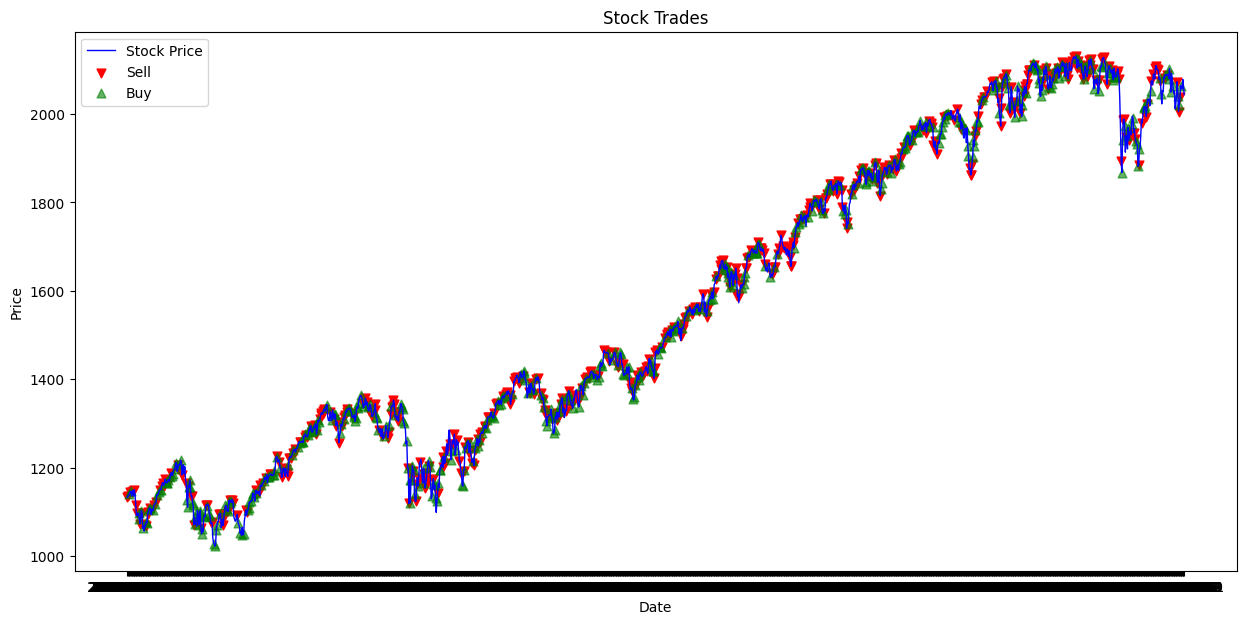

episode: 7/10 score: 11601.947784850847


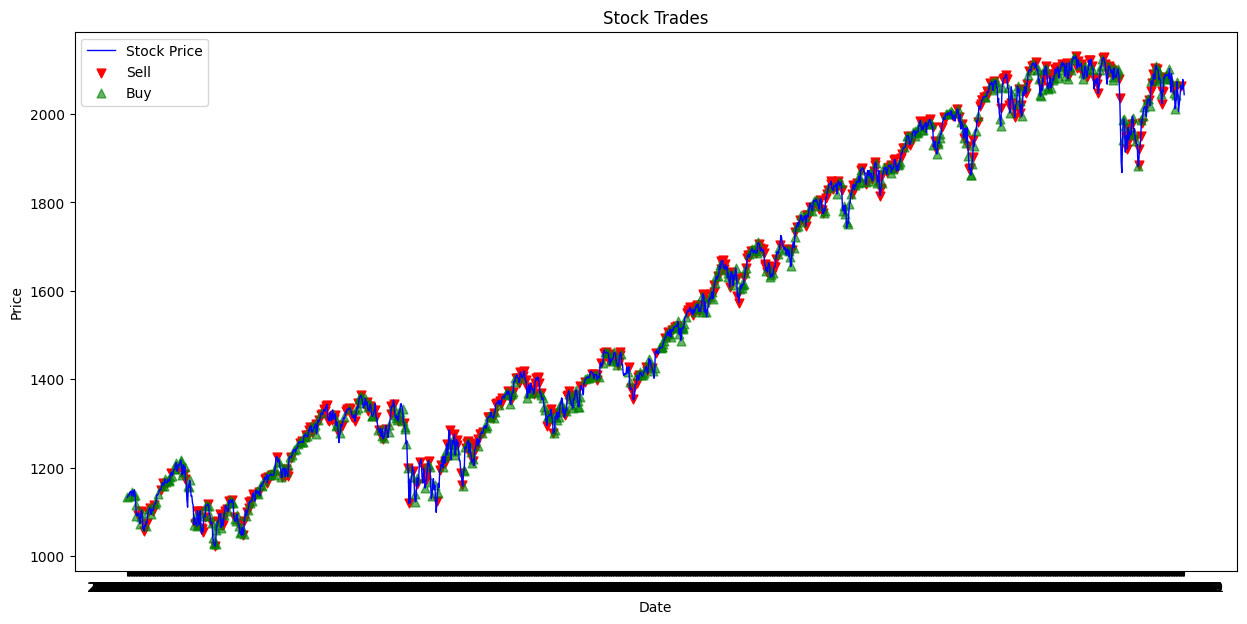

episode: 8/10 score: 9191.204367316961


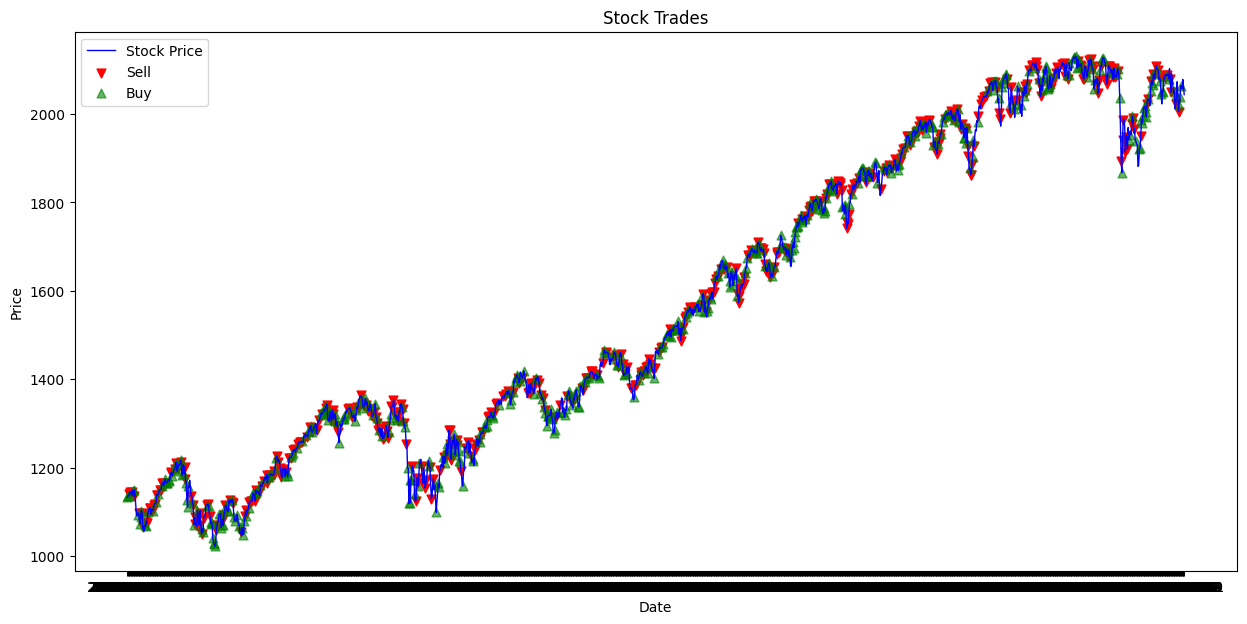

episode: 9/10 score: 9270.400350353575


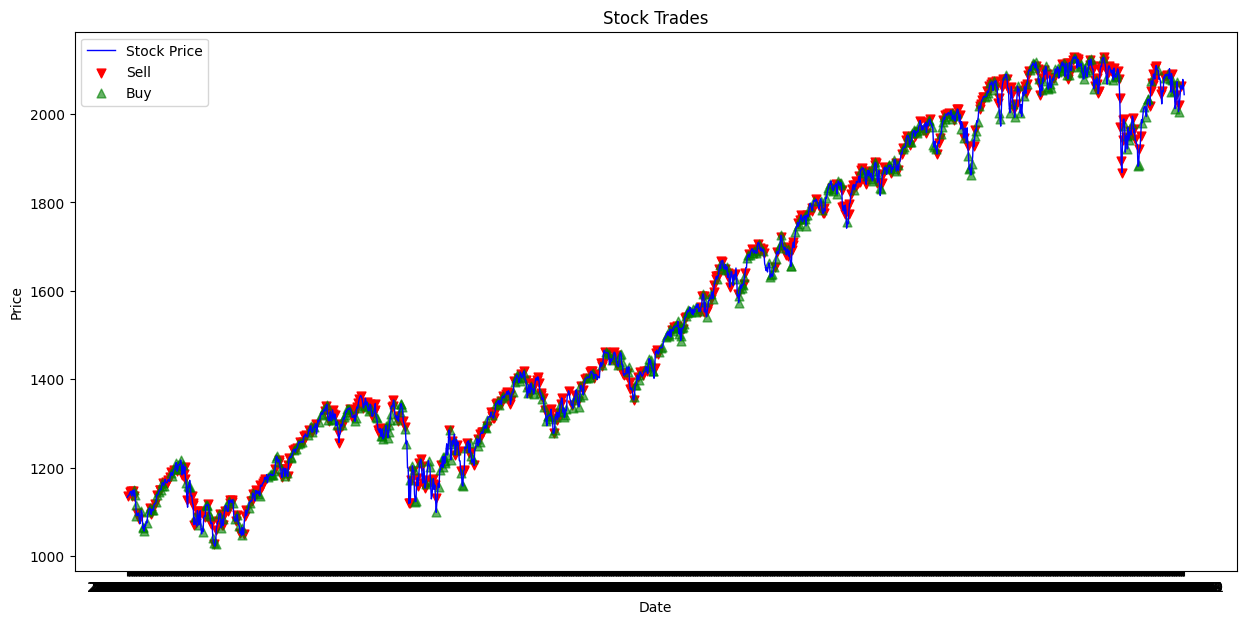

episode: 10/10 score: 11238.645405488562


<Figure size 640x480 with 0 Axes>

In [ ]:
# Evaluation
def evaluate(env, agent, episodes=10):
    # total_rewards = 0
    networths = []
    for e in range(episodes):
        trades = []
        state, _ = env.reset()
        state = state.flatten()
        for time in range(len(env.df)):
            action = agent.act(state)
            next_state, reward, done, truncated, _ = env.step(action)
            trades.append((env.current_step, action[0], action[1]))  # Log the trade action
            next_state = next_state.flatten()
            # total_rewards += reward
            state = next_state
        plt.figure(figsize=(15, 7))

        # Plot stock price with a thinner line
        plt.plot(env.df['Date'], env.df['Close'], label='Stock Price', linewidth=1, color='b')

        # Extract buy and sell trades
        buy_trades = [trade for trade in trades if trade[1] == 0]
        sell_trades = [trade for trade in trades if trade[1] == 1]

        plt.scatter(env.df.loc[[trade[0] for trade in sell_trades], 'Date'], 
                    env.df.loc[[trade[0] for trade in sell_trades], 'Close'], 
                    marker='v', color='r', s=40, label='Sell', alpha=1)
        
        plt.scatter(env.df.loc[[trade[0] for trade in buy_trades], 'Date'], 
                    env.df.loc[[trade[0] for trade in buy_trades], 'Close'], 
                    marker='^', color='g', s=40, label='Buy', alpha=0.6)


        # Labels and title
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.title('Stock Trades')

        # Show legend
        plt.legend()

        # Show plot
        plt.show()
        print(f"episode: {e+1}/{episodes} score: {env.net_worth}")
        networths.append(env.net_worth)
    
    print(f"Average net worth over {episodes} episodes: {sum(networths)/episodes}")
    

# Evaluate the agent
# agent = Agent(state_dim=state_dim)
agent = Agent(state_dim=state_dim,is_eval=True, model_name="model_dqn_temp.pth")
evaluate(env, agent)
plt.savefig('saved_visuals/dqn_eval1.jpeg')